In [1]:
# test full training of maskcnn_polished_with_rcnn_k_bl
from os.path import join

import numpy as np

import torch

from thesis_v2 import dir_dict

from thesis_v2.data.prepared.yuanyuan_8k import get_data

from thesis_v2.training_extra.maskcnn_like.opt import get_maskcnn_v1_opt_config
from thesis_v2.training_extra.maskcnn_like.training import (train_one,
                                                            partial)

from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import (
    gen_maskcnn_polished_with_rcnn_k_bl,
    load_modules
)



In [2]:
def train_one_maskcnn_polished_with_rcnn_k_bl(
    split_seed,
    model_seed,
    act_fn,
    loss_type,
    input_size,
    out_channel,
    num_layer,
    kernel_size_l1,
    pooling_ksize,
    scale, scale_name,
    smoothness, smoothness_name,
    pooling_type,
    n_timesteps,
):
    
    load_modules()
    datasets = get_data('a', 200, input_size, ('042318', '043018', '051018'), scale=0.5,
                        seed=split_seed)

    datasets = {
        'X_train': datasets[0].astype(np.float32),
        'y_train': datasets[1],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }

    def gen_cnn_partial(input_size_cnn, n):
        return gen_maskcnn_polished_with_rcnn_k_bl(
                                    input_size=input_size_cnn,
                                    num_neuron=n,
                                    out_channel=out_channel,
                                    kernel_size_l1=kernel_size_l1,  # (try 5,9,13)
                                    kernel_size_l23=3,
                                    act_fn=act_fn,
                                    pooling_ksize=pooling_ksize,  # (try, 1,3,5,7)
                                    pooling_type=pooling_type,  # try (avg, max)  # looks that max works well here?
                                    num_layer=num_layer,
                                    n_timesteps=n_timesteps,
                                    factored_constraint=None,
                                    blstack_pool_ksize=1,
                                    blstack_pool_type=None,
                                    acc_mode='cummean',
                                    bn_after_fc=False,
                                    ff_1st_block=True,
                                    )

    opt_config_partial = partial(get_maskcnn_v1_opt_config,
                                 scale=scale,
                                 smoothness=smoothness,
                                 group=0.0,
                                 loss_type=loss_type,
                                 )
    
    result = train_one(
        arch_json_partial=gen_cnn_partial,
        opt_config_partial=opt_config_partial,
        datasets=datasets,
        key=f'debug/test_full_training_maskcnn_polished_with_rcnn_k_bl/ff_1st_block_multipath/{model_seed}',
        show_every=100,
        max_epoch=40000,
        model_seed=model_seed,
        return_model=False,
        extra_params={
            # reduce on batch axis
            'eval_fn': {
                'yhat_reduce_axis': 1,
            }
        },
        print_model=True
    )
    
    return result['stats_best']['stats']['test']['corr_mean']

In [3]:
maskcnn_param_template = {
    'out_channel': 16,
    'num_layer': 3,
    'kernel_size_l1': 9,
    'pooling_ksize': 3,
    'pooling_type': 'avg',
    'model_seed': 0,
    'split_seed': 'legacy',
}

maskcnn_param_regular = {
    **maskcnn_param_template,
    **{
        'act_fn': 'relu',
        'loss_type': 'mse',
        'smoothness': 0.000005,
        'smoothness_name': '0.000005',
        'scale': 0.01,
        'scale_name': '0.01',
        'input_size': 50,
        'n_timesteps': 4,
    }
}

print(train_one_maskcnn_polished_with_rcnn_k_bl(**maskcnn_param_regular))

# 27629 = 1*2 + 16*1*9*9 + 16*2 + 2*(16*16*3*3+16*16*3*3+4*16*2) + 79*(14*14 + 16 + 1) 

# results here are exactly the same as those in `scripts/debug/rcnn_basic_kriegeskorte/test_full_training_ff_1st.ipynb`

{'final_act', 'fc', 'bn_output', 'pooling'}
['conv0', 'bl_stack.layer_list.0.b_conv', 'bl_stack.layer_list.1.b_conv']
num_param 27629
JSONNet(
  (moduledict): ModuleDict(
    (accumulator): RecurrentAccumulator()
    (act0): ReLU()
    (bl_stack): BLConvLayerStack(
      (layer_list): ModuleList(
        (0): BLConvLayer(
          (b_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (l_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): BLConvLayer(
          (b_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (l_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bn_layer_list): ModuleList(
        (0): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (

In [4]:
from torch import nn, no_grad, float32, tensor

In [5]:
# then let's make sure that my multi-path ensemble is implemented correctly.

# at least, when all bias is zero, and there is NO activation function, and there is no duplication of BN layer,
# multi path should give exactly the same result as original model

def check_result(multi_path):
    
    
    
    key = 'debug/test_full_training_maskcnn_polished_with_rcnn_k_bl/ff_1st_block_multipath/0'
    def gen_cnn_partial(input_size_cnn, n):
        return gen_maskcnn_polished_with_rcnn_k_bl(
                                    input_size=input_size_cnn,
                                    num_neuron=n,
                                    out_channel=maskcnn_param_regular['out_channel'],
                                    kernel_size_l1=maskcnn_param_regular['kernel_size_l1'],  # (try 5,9,13)
                                    kernel_size_l23=3,
                                    act_fn=maskcnn_param_regular['act_fn'],
                                    pooling_ksize=maskcnn_param_regular['pooling_ksize'],  # (try, 1,3,5,7)
                                    pooling_type=maskcnn_param_regular['pooling_type'],  # try (avg, max)  # looks that max works well here?
                                    num_layer=maskcnn_param_regular['num_layer'],
                                    n_timesteps=maskcnn_param_regular['n_timesteps'],
                                    factored_constraint=None,
                                    blstack_pool_ksize=1,
                                    blstack_pool_type=None,
                                    acc_mode='cummean',
                                    bn_after_fc=False,
                                    ff_1st_block=True,
            act_fn_inner=None,  # no act for innner blocks
            ff_1st_bn_before_act=None,
            multi_path=multi_path,
            multi_path_separate_bn=False if multi_path else None
                                    )
    model_json = gen_cnn_partial(50, 79)
    model_this = load_training_results(key, return_model=True, model=build_net(model_json))['model']
    model_this.eval()
    print(model_this)
    print(model_this.get_module('bl_stack').multi_path, model_this.get_module('bl_stack').multi_path_separate_bn)
    
    
    for name, mod in model_this.named_modules():
        # all bias parameters will duplicate their effects in the multi chain analysis.
        if isinstance(mod, nn.BatchNorm2d):
            print(name)
            with no_grad():
                mod.bias.zero_()
                mod.running_mean.zero_()
    
    # pass in some images and see the response
    rng_state = np.random.RandomState(seed=0)
    with no_grad():
        images = tensor(rng_state.rand(10, 1, 50, 50)*255, dtype=float32)
        responses = model_this(images)
        assert len(responses) == 1
        responses = responses[0].numpy()
    
    return responses
        

In [6]:
from thesis_v2.training.training_aux import load_training_results
from torchnetjson.builder import build_net

resp_old = check_result(False)

{'final_act', 'fc', 'bn_output', 'pooling'}
JSONNet(
  (moduledict): ModuleDict(
    (accumulator): RecurrentAccumulator()
    (bl_stack): BLConvLayerStack(
      (layer_list): ModuleList(
        (0): BLConvLayer(
          (b_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (l_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): BLConvLayer(
          (b_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (l_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bn_layer_list): ModuleList(
        (0): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (3): BatchNorm2d(

In [7]:
resp_new = check_result(True)

{'final_act', 'fc', 'bn_output', 'pooling'}
JSONNet(
  (moduledict): ModuleDict(
    (accumulator): RecurrentAccumulator()
    (bl_stack): BLConvLayerStack(
      (layer_list): ModuleList(
        (0): BLConvLayer(
          (b_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (l_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): BLConvLayer(
          (b_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (l_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bn_layer_list): ModuleList(
        (0): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (3): BatchNorm2d(

In [8]:
resp_new.shape

(4, 10, 79)

In [9]:
resp_old.shape

(4, 10, 79)

In [10]:
assert resp_new.shape == resp_old.shape
assert np.allclose(resp_new, resp_old, atol=1e-5)

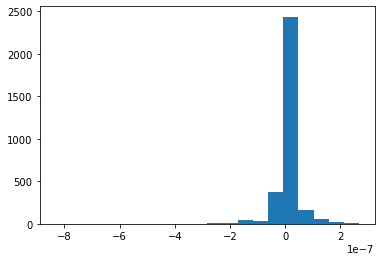

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')
plt.hist(resp_old.ravel()-resp_new.ravel(), bins=20)
plt.show()